In [1]:
import numpy as np

features_files = [
    '/kaggle/input/scenicornot/array_immagini224_completo11voti1.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti2.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti3.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti4.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti5.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti6.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti7.npy',
    '/kaggle/input/scenicornot/array_immagini224_completo11voti8.npy'
]
votes_files = [
    '/kaggle/input/scenicornot/array_voti_completo11voti1.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti2.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti3.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti4.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti5.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti6.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti7.npy',
    '/kaggle/input/scenicornot/array_voti_completo11voti8.npy'
]

features = []
votes = []

for features_file, votes_file in zip(features_files, votes_files):
    features_array = np.load(features_file, allow_pickle=True)
    votes_array = np.load(votes_file, allow_pickle=True)
    
    features.append(features_array)
    votes.append(votes_array)
    
    # Elimina gli array singoli
    del features_array, votes_array

# Concatena gli array
features = np.concatenate(features, axis=0)
votes = np.concatenate(votes, axis=0)

In [2]:
print(features.shape, votes.shape)

(22472, 224, 224, 3) (22472, 10)


In [3]:
# ridimensionamento immagini per velocizzare addestramento

import tensorflow as tf

features_red = []

for i in range(len(features)):
    features_red.append(tf.image.resize(features[i,:,:,:], [96,96]))
features = np.array(features_red)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
# riduzione dei valori di pixel tra 0 e 1
features  = features/255

In [5]:
# one hot encoding su 3 classi

votes = tf.argmax(tf.stack([tf.reduce_sum(votes[:, :3], axis=1), tf.reduce_sum(votes[:, 3:6], axis=1), tf.reduce_sum(votes[:, 6:], axis=1)], axis=1), axis=1) 


In [6]:
votes = tf.one_hot(votes, depth=3)

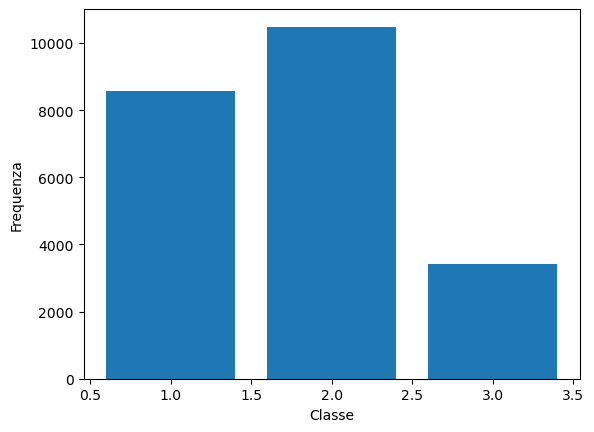

In [7]:
import matplotlib.pyplot as plt

# Calcola la frequenza delle classi
class_frequencies = np.sum(votes, axis=0)

# Crea l'istogramma delle frequenze
plt.bar(range(1, 4), class_frequencies)

# Aggiungi etichette agli assi
plt.xlabel('Classe')
plt.ylabel('Frequenza')

# Mostra l'istogramma
plt.show()

In [8]:
# augmentation

import imgaug.augmenters as iaa
import tensorflow as tf

def augment_data(images, labels):
    augmenter = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05)),
        iaa.Fliplr(0.5)
    ])
    
    augmented_images = list(images) 
    augmented_labels = list(labels)
    
    for i in range(len(images)):
        top_label = tf.argmax(labels[i])
        if top_label > 1:
            augmented_image = augmenter.augment_image(images[i,:,:,:])
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])
    return np.array(augmented_images), np.array(augmented_labels)

aug_features, aug_votes = augment_data(features, votes)

In [9]:
del features
aug_features.shape

(25881, 96, 96, 3)

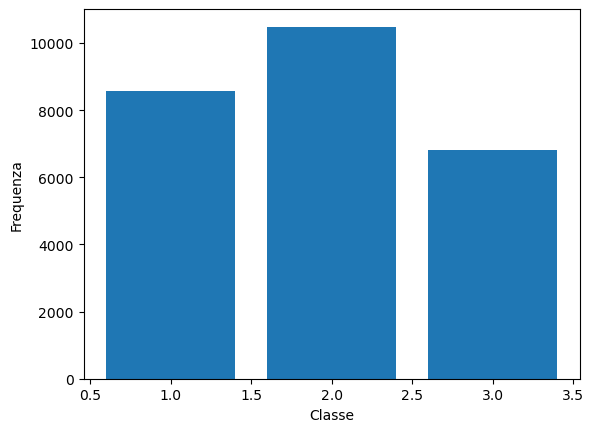

In [10]:
# Calcola la frequenza delle classi
class_frequencies = np.sum(aug_votes, axis=0)

# Crea l'istogramma delle frequenze
plt.bar(range(1, 4), class_frequencies)

# Aggiungi etichette agli assi
plt.xlabel('Classe')
plt.ylabel('Frequenza')

# Mostra l'istogramma
plt.show()

In [11]:
tf.random.set_seed(582) #per riproducibilità

In [12]:
from sklearn.model_selection import train_test_split

trainval_features, test_features, trainval_target, test_target = train_test_split(aug_features, aug_votes, test_size=0.2)

# controllo training set
print('TRAINING SET:\t',trainval_features.shape)

# controllo test set
print('TEST SET:\t',test_features.shape)

TRAINING SET:	 (20704, 96, 96, 3)
TEST SET:	 (5177, 96, 96, 3)


In [13]:
del aug_features

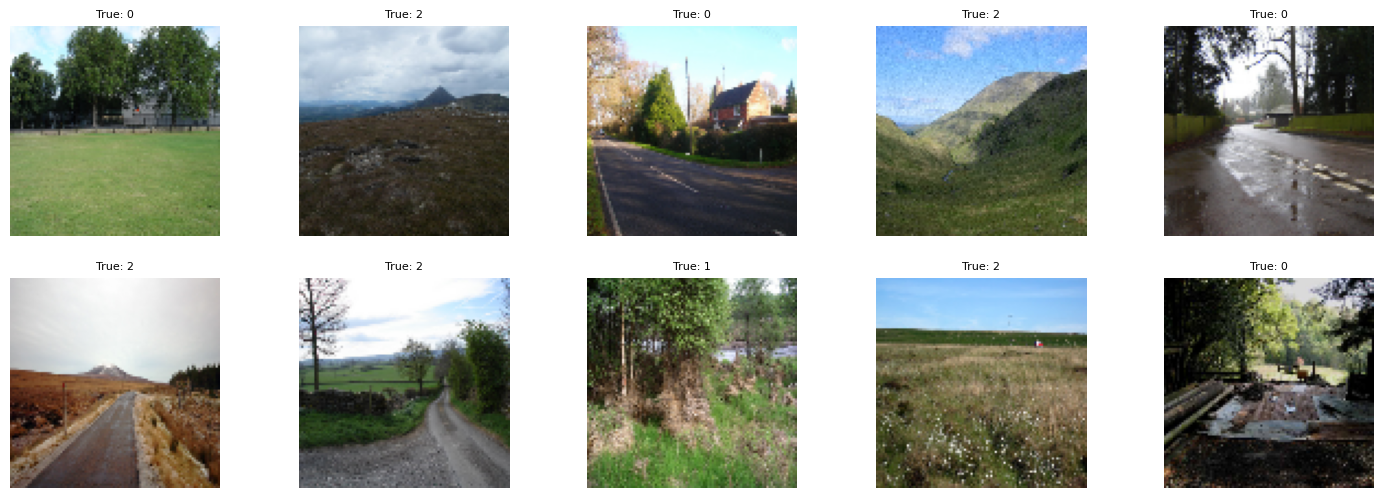

In [15]:
# visualizzare le prime 10 immagini e lable
fig, axs = plt.subplots(2,5,figsize=(18,6))

for i in np.arange(70,80):

    ax = axs.ravel()[i-70]
        
    ax.imshow(trainval_features[i], cmap='gray')
    ax.set_title('True: {}'.format(tf.argmax(trainval_target[i])), fontsize=8)
    ax.axis('off')

In [16]:
# validazione

indices = np.arange(len(trainval_features))

train_features, val_features, train_target, val_target = train_test_split(trainval_features, trainval_target, test_size=0.1)

# controllo training set
print('TRAINING SET:\t',train_features.shape)

# controllo validation set
print('VALIDATION SET:\t',val_features.shape)

TRAINING SET:	 (18633, 96, 96, 3)
VALIDATION SET:	 (2071, 96, 96, 3)


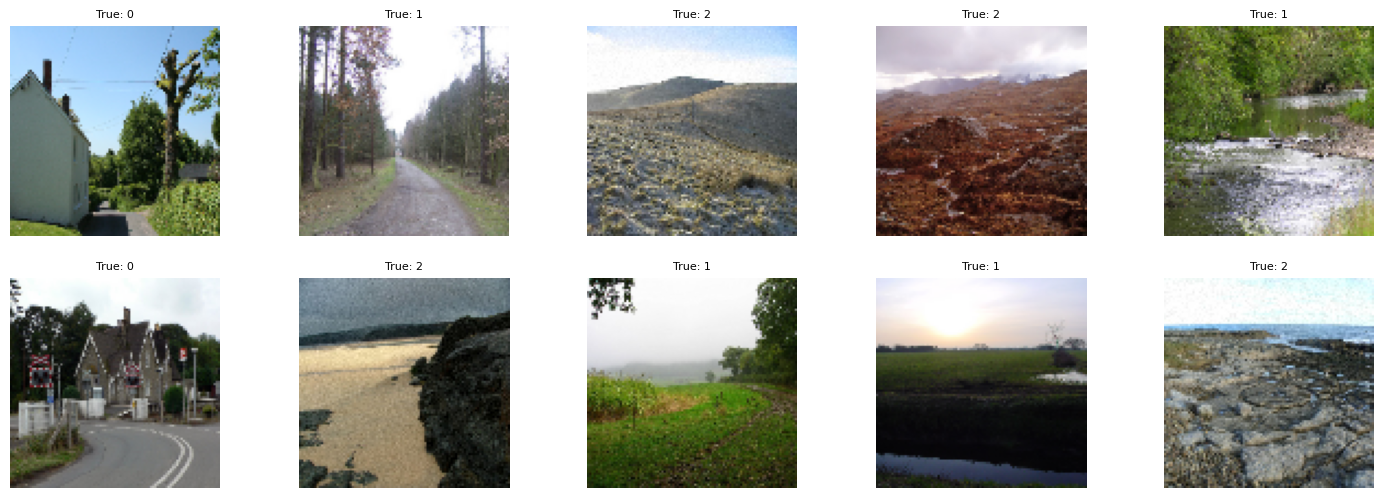

In [18]:
# visualizzare le prime 10 immagini e lable
fig, axs = plt.subplots(2,5,figsize=(18,6))

for i in np.arange(70,80):

    ax = axs.ravel()[i-70]
        
    ax.imshow(train_features[i], cmap='gray')
    ax.set_title('True: {}'.format(tf.argmax(train_target[i])), fontsize=8)
    ax.axis('off')

In [24]:
#import generic model class
from tensorflow import keras
from tensorflow.keras import Model, Input,regularizers

#import the types of layes we need
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Reshape, AvgPool2D, Dropout

#very important! do it before you instantiate a brand new model
#cleares the backend of all the previous instances of the models 
#which might interfere with the new instance
keras.backend.clear_session()

In [25]:
#we intend to pass as inputs images of shape 28x28 with only one channel
#convolutional layers need to have the number of input channels explicitely specified

#specificare inizializzazione
initializer = tf.keras.initializers.GlorotUniform()


inputs = Input(shape=(96,96,3)) 

#C1
x = Conv2D(filters=6, kernel_size=(5,5), padding='same', strides=(1,1), activation='relu')(inputs)

#S2
x = MaxPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C3
x = Conv2D(filters=16, kernel_size=(5,5), padding='valid', strides=(1,1), activation='relu')(x)

#S4
x = AvgPool2D(pool_size=(2,2), strides=(2,2),  padding='valid')(x)

#C5
x = Conv2D(filters=256, kernel_size=(7,7), padding='valid', strides=(1,1), activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)

#flatten the feature maps
x = Flatten()(x)

#F7
x = Dense(84, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)


dropout_rate = 0.1  # Tasso di dropout desiderato
x = Dropout(rate=dropout_rate)(x)

#output layer with softmax for classification
outputs = Dense(3, activation='softmax')(x)


#build model
#NOTE: when building the network in this way, keras only needs tha inputs and the outputs of the model:
#it will automatically reconstruct all of the dependencies that we declared before!
shallow_model = Model(inputs=inputs, outputs=outputs, name='basic_convolution')

In [26]:
# definizione della loss e compilazione
from tensorflow.keras import optimizers

def custom_crossentropy(y_true, y_pred):
    prob_pred_val = tf.multiply(y_pred, tf.range(1, tf.shape(y_pred)[-1] + 1, dtype=y_pred.dtype))
    entropia_dato = tf.reduce_sum(tf.multiply(tf.math.log(tf.multiply(prob_pred_val, y_pred)), y_true), axis=1)
    entropia = -entropia_dato
    return tf.reduce_mean(entropia)

def custom_accuracy(y_true, y_pred):
    # Calcolo degli indici degli elementi massimi
    pred_max_indices = tf.argmax(y_pred, axis=1) + 1
    # Calcolo delle medie arrotondate
    true_rounded_means = tf.round(tf.reduce_mean(y_true, axis=1))
    # Calcolo della frazione di elementi uguali
    accuracy = tf.reduce_mean(tf.cast(tf.less_equal(tf.abs(tf.cast(pred_max_indices, dtype=tf.float32) - true_rounded_means), 2), dtype=tf.float32))
    return accuracy

def custom_mean_error(y_true, y_pred):
    # Calcolo degli indici degli elementi massimi in y_true e y_pred
    true_max_indices = tf.argmax(y_true, axis=1)+1
    pred_max_indices = tf.argmax(y_pred, axis=1)+1
    # Calcolo dell'errore medio del batch
    error = tf.reduce_mean(tf.abs(true_max_indices - pred_max_indices))
    return error

def macro_accuracy(y_true, y_pred):
    true_stacked = tf.stack([tf.reduce_sum(y_true[:, :3], axis=1), tf.reduce_sum(y_true[:, 3:6], axis=1), tf.reduce_sum(y_true[:, 6:], axis=1)], axis=1)
    pred_stacked = tf.stack([tf.reduce_sum(y_pred[:, :3], axis=1), tf.reduce_sum(y_pred[:, 3:6], axis=1), tf.reduce_sum(y_pred[:, 6:], axis=1)], axis=1)
    
    true_macroclass = tf.argmax(true_stacked, axis=1)
    pred_macroclass = tf.argmax(pred_stacked, axis=1)

    # Calcola l'accuratezza delle predizioni sulle macroclassi
    accuracy = tf.reduce_mean(tf.cast(tf.equal(true_macroclass, pred_macroclass), tf.float32))
    return accuracy

learning_rate = 0.05

shallow_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',#optimizers.SGD(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [27]:
# definizione iperparametri batch size e epoche

epochs = 20
batch_size = 64

In [28]:
# training del modello

history = shallow_model.fit(
    train_features,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(val_features,val_target),
    verbose=1 
)

Epoch 1/20
292/292 [==============================] - 180s 613ms/step - loss: 1.0249 - accuracy: 0.5047 - val_loss: 0.9546 - val_accuracy: 0.5693
Epoch 2/20
292/292 [==============================] - 187s 641ms/step - loss: 0.9490 - accuracy: 0.5490 - val_loss: 0.9339 - val_accuracy: 0.5664
Epoch 3/20
292/292 [==============================] - 181s 619ms/step - loss: 0.9315 - accuracy: 0.5611 - val_loss: 0.9486 - val_accuracy: 0.5514
Epoch 4/20
292/292 [==============================] - 178s 609ms/step - loss: 0.9050 - accuracy: 0.5831 - val_loss: 0.9456 - val_accuracy: 0.5340
Epoch 5/20
292/292 [==============================] - 175s 600ms/step - loss: 0.8862 - accuracy: 0.5899 - val_loss: 0.9142 - val_accuracy: 0.5765
Epoch 6/20
292/292 [==============================] - 176s 604ms/step - loss: 0.8826 - accuracy: 0.5932 - val_loss: 0.8876 - val_accuracy: 0.5973
Epoch 7/20
292/292 [==============================] - 175s 601ms/step - loss: 0.8696 - accuracy: 0.6037 - val_loss: 0.8987 -

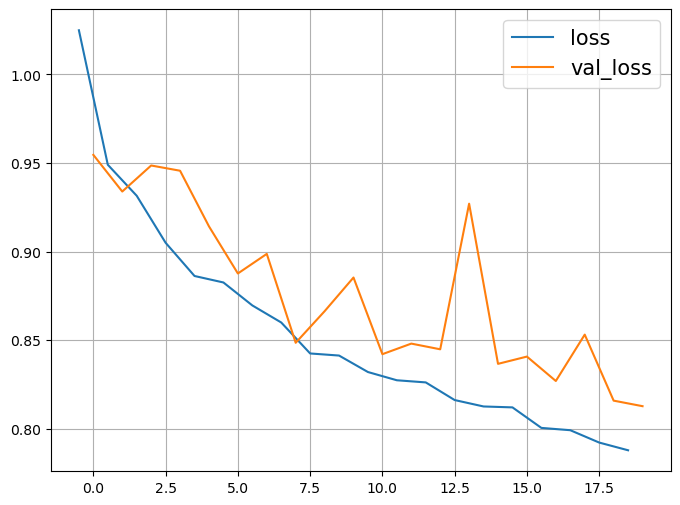

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    if metric!='accuracy' and metric!='val_accuracy':
    
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
        else:
            ax.plot(history.epoch, history.history[metric], label=metric)
    
    
ax.grid()
#plt.ylim(2,4)    

ax.legend(fontsize=15);

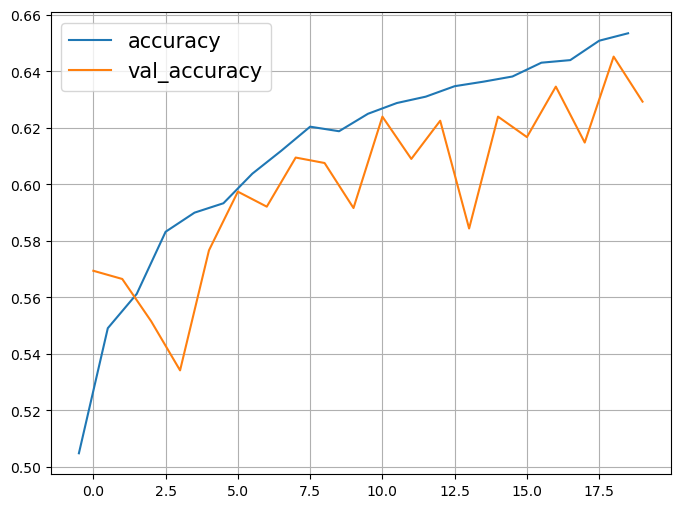

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    if metric!='loss' and metric!='val_loss':
    
        #subtract half epoch from training data
        if len(metric.split('_')) < 2:
            ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
        else:
            ax.plot(history.epoch, history.history[metric], label=metric)
    
    
ax.grid()
#plt.ylim(2,4)    

ax.legend(fontsize=15);

In [31]:
# proseguire training per 5 epoche


history = shallow_model.fit(
    train_features,
    train_target,
    epochs=5,
    batch_size=batch_size,
    validation_data=(val_features,val_target),
    verbose=1 
)

Epoch 1/5
292/292 [==============================] - 178s 611ms/step - loss: 0.7818 - accuracy: 0.6575 - val_loss: 0.8098 - val_accuracy: 0.6456
Epoch 2/5
292/292 [==============================] - 179s 612ms/step - loss: 0.7755 - accuracy: 0.6636 - val_loss: 0.8330 - val_accuracy: 0.6335
Epoch 3/5
292/292 [==============================] - 177s 607ms/step - loss: 0.7763 - accuracy: 0.6629 - val_loss: 0.8286 - val_accuracy: 0.6354
Epoch 4/5
292/292 [==============================] - 176s 603ms/step - loss: 0.7725 - accuracy: 0.6655 - val_loss: 0.8715 - val_accuracy: 0.6195
Epoch 5/5
292/292 [==============================] - 179s 612ms/step - loss: 0.7646 - accuracy: 0.6733 - val_loss: 0.8215 - val_accuracy: 0.6379


In [32]:
#evaluate model on the test set
test_loss, test_acc = shallow_model.evaluate(test_features, test_target)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

162/162 [==============================] - 14s 88ms/step - loss: 0.8131 - accuracy: 0.6469

Test Loss:	 0.8131340742111206
Test Accuracy:	 0.6468997597694397


In [33]:
y_test_pred = shallow_model.predict(test_features)

162/162 [==============================] - 14s 83ms/step


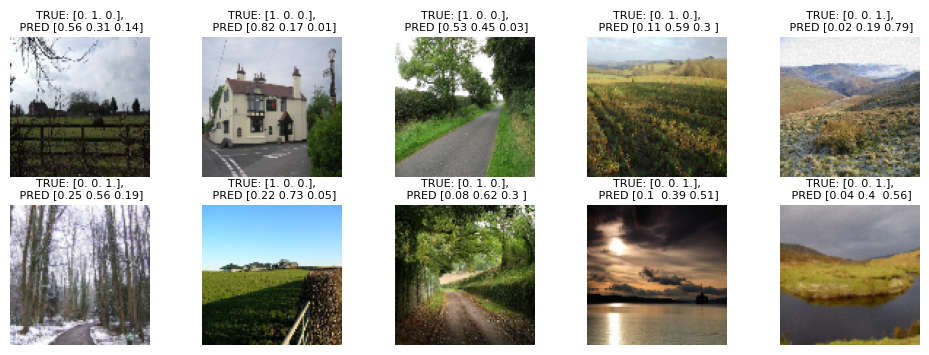

In [36]:
random_rows = np.random.choice(y_test_pred.shape[0], size=10, replace=False)

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = random_rows[i]
    
    ax.imshow(test_features[idx], cmap='gray')
    ax.set_title('TRUE: {},\n PRED {}'.format(test_target[idx], np.round(y_test_pred[idx],decimals=2)), fontsize=8)
    ax.axis('off')

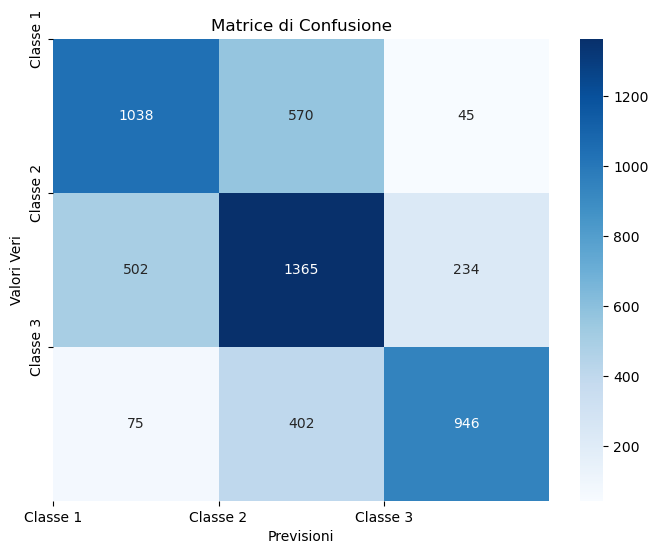

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convertire le previsioni softmax in vettori di classe predetti
y_pred_classes = np.argmax(y_test_pred, axis=1)

# Convertire i vettori target one hot encoded in vettori di classe veri
y_true_classes = np.argmax(test_target, axis=1)  # y_true sono i target one hot encoded

# Calcolare la matrice di confusione
confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Creare la figura e l'asse dei grafici
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")

# Aggiungere etichette agli assi
class_labels = ["Classe 1", "Classe 2", "Classe 3"]  # Modifica le etichette delle classi in base alle tue classi
plt.xlabel("Previsioni")
plt.ylabel("Valori Veri")
plt.xticks(np.arange(len(class_labels)), class_labels)
plt.yticks(np.arange(len(class_labels)), class_labels)

# Mostrare la matrice di confusione
plt.title("Matrice di Confusione")
plt.show()

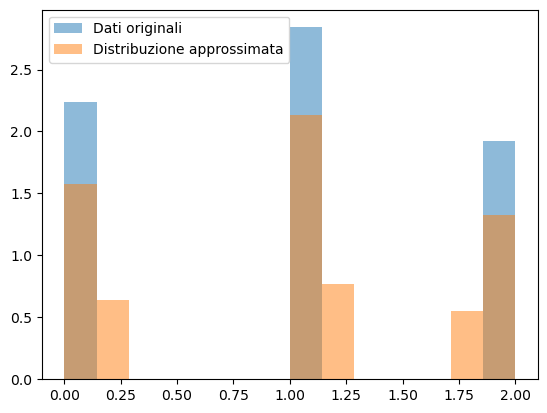

In [37]:
# confronto con modello nullo 3 classi

# costruzione del modello nullo
from scipy import stats

# Genera un istogramma 
hist, bin_edges = np.histogram(y_true_classes)

# Approssima l'istogramma a una distribuzione di probabilità
dist = stats.rv_histogram((hist, bin_edges))

# Genera alcuni valori casuali dalla distribuzione approssimata
samples = dist.rvs(size=len(test_target))

# Visualizza l'istogramma e la distribuzione approssimata
plt.hist(y_true_classes, bins='auto', density=True, alpha=0.5, label='Dati originali')
plt.hist(samples, bins='auto', density=True, alpha=0.5, label='Distribuzione approssimata')
plt.legend()
plt.show()

In [44]:
# accuracy su 3 classi del random sample

np.sum(np.equal(np.round(samples),y_true_classes))/len(y_true_classes)

0.3415105273324319

In [45]:
np.sum(np.equal(y_pred_classes,y_true_classes))/len(y_true_classes)

0.6468997488893181